# First Things First

Welcome to our very first introduction to *TensorFox*, a specialized library made to deal with 3D tensors, with focus on the CPD (Canonical Polyadic Decomposition). In order to have everything working properly, all files of TensorFox must be in the same folder of your program. Another option is to add all modules to your Python path, if more convenient. To be able to use TensorFox you will need the following modules:

- numpy

- scipy

- time

- matplotlib

- numba

- decimal

Also make sure Numpy is using a nice version of BLAS. That is all! TensorFox is read to go! Let's start importing TensorFox and other necessary modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import TensorFox as tfx

# Creating Tensors and Getting Information 

Let's create a little tensor $T$ just to see how TensorFox works at its basics. It is important to notice that TensorFox only works with tensors as 3D numpy arrays. 

Our convention is that $T[i,j,k]$ refers to the $i$-th row, $j$-column and $k$-section (frontal slice) of $T$. For instance, consider the tensor defined by $T[i,j,k] = i+j+k$ for $i,j,k = 0,1$. This tensor should be seen as

$$T = \left\{ \left[
\begin{array}{cc}
    0 & 1\\
    1 & 2
\end{array}
\right], \quad
\left[
\begin{array}{cc}
    1 & 2\\
    2 & 3
\end{array}
\right] \right\},$$
where each matrix is a frontal slice of $T$. 

Since Numpy's convention is different from ours, we have a special command to print $T$ by slices. This is the function **showtens**. Using the **print** function will show a different $T$ and this can lead to confusion.

In [2]:
# Create and print the tensor, which is 2 x 2 x 2.
m = 2
T = np.zeros((m, m, m))
for i in range(m):
    for j in range(m):
        for k in range(m):
            T[i,j,k] = i+j+k
            
Tsize = np.linalg.norm(T)            
tfx.showtens(T)

[[0. 1.]
 [1. 2.]]

[[1. 2.]
 [2. 3.]]



There are lots of questions we can make about a given tensor $T$: what are its maximum and minimum entries, what are the dimensions of $T$, the rank and multirank, etc.

Even in the case of the simple tensor above we can't know all these answers in advance. The function **infotens** tries to compute all these informations for your convenience. This function is useful for small tensors, but remember that finding the rank is a NP-hard task, so don't abuse. 

T is a tensor of dimensions 2 x 2 x 2

|T| = 4.898979485566356

max(T) = 3.0

min(T) = 0.0

1 <= rank(T) <= 4

multirank(T) = 2 , 2 , 2

Start searching for rank
------------------------------------
Stops at r = 4  or less

Testing r = 1
Testing r = 2
Testing r = 3
------------------------------------
Estimated rank(T) = 3
|T - T_approx|/|T| = 1.3449899533011237e-06


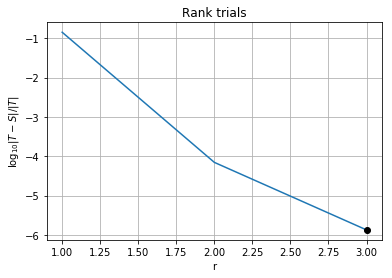

In [3]:
# Let's see some information about T.
tfx.infotens(T)

# Computing the CPD

Now let's turn to the most important tool of TensorFox, the computation of the CPD. As the previous function hinted, $T$ should have rank 2 (but don't believe blindly in this function). We can compute the corresponding CPD with the function **cpd**.

In [4]:
# Compute the CPD of T, assuming T has rank 2.
r = 2
Lambda, X, Y, Z, T_approx, info = tfx.cpd(T, r)

# Show the CPD computed. 
print('Lambda =\n',Lambda)
print()
print('X =\n', X)
print()
print('Y =\n', Y)
print()
print('Z =\n', Z)
print()

# Show the coordinate representation of this CPD.
print('T_approx =')
tfx.showtens(T_approx)

# Show relative error of this approximation.
print('|T - T_approx|/|T| =', info.rel_error)

Lambda =
 [42.522135   46.76477576]

X =
 [[ 0.7184955  -0.69607329]
 [ 0.6955316  -0.71797073]]

Y =
 [[0.7184955  0.69607329]
 [0.6955316  0.71797073]]

Z =
 [[-0.7184955  -0.69607329]
 [-0.6955316  -0.71797073]]

T_approx =
[[-1.25530468e-04  1.00012574e+00]
 [ 1.00012574e+00  1.99987419e+00]]

[[1.00012574 1.99987419]
 [1.99987419 3.00012577]]

|T - T_approx|/|T| = 7.259849971609646e-05


This solution means we can write the CPD of $T$ as

$$T \approx \small 42.522 \cdot 
\left[
\begin{array}{c}
    0.7184955\\
    0.6955316
\end{array}
\right]
\otimes
\left[
\begin{array}{c}
    0.7184955\\
    0.6955316
\end{array}
\right]
\otimes
\left[
\begin{array}{c}
    -0.7184955\\
    -0.6955316
\end{array}
\right] 
+ 46.764 \cdot
\left[
\begin{array}{c}
    -0.69607329\\
    -0.71797073
\end{array}
\right]
\otimes
\left[
\begin{array}{c}
    0.69607329\\
    0.71797073
\end{array}
\right]
\otimes
\left[
\begin{array}{c}
    -0.69607329\\
    -0.71797073
\end{array}
\right].$$

Note that all vectors have Euclidean norm equal to 1. Their magnitudes are aggregate in the $\Lambda$ factors.

The outputs **step_sizes, errors** need a more detailed explanation. When we compute the CPD, there are two stages: the *main stage* and the *refinement stage*. Each one of the mentioned outputs is a list, where the first element is the array corresponding to the main stage and the second element correspond to the refinement stage.

Below we show a plot of the **step_sizes** arrays. They represent the size of each step taken in the iterative process. Ideally, we want to take larger steps at the beggining (when the current tensor is far from to the objective tensor) and smaller steps at the final (when the current tensor is closer to the objective tensor). 

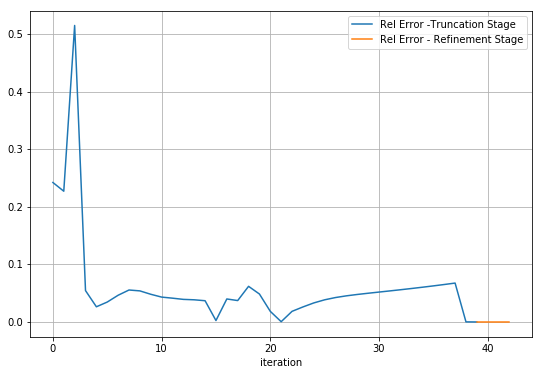

In [5]:
# Plot the step sizes of the iterations.
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 9
fig_size[1] = 6

a = len(info.errors[0])
b = len(info.errors[1])

plt.plot(np.arange(0, a), info.step_sizes[0]/Tsize,'-' , markersize=2, label='Rel Error -Truncation Stage')
plt.plot(np.arange(a-1, a+b-1), info.step_sizes[1]/Tsize, '-', markersize=2, label='Rel Error - Refinement Stage')
plt.xlabel('iteration')
plt.grid()
plt.legend()
plt.show()

The **errors** arrays represent the absolute error at each step, so we divide them by the norm of $T$ in order to have the plot of relative errors. 

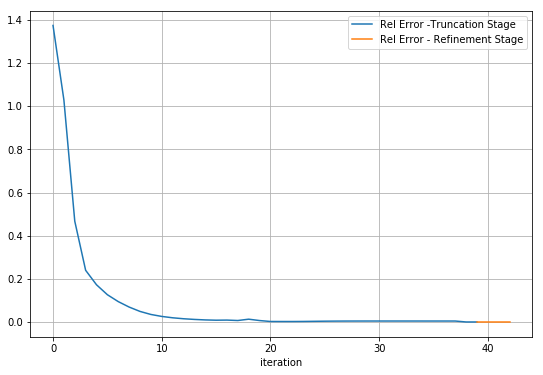

In [6]:
# Plot the step sizes of the iterations.
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 9
fig_size[1] = 6

a = len(info.errors[0])
b = len(info.errors[1])

plt.plot(np.arange(0, a), info.errors[0]/Tsize,'-' , markersize=2, label='Rel Error -Truncation Stage')
plt.plot(np.arange(a-1, a+b-1), info.errors[1]/Tsize, '-', markersize=2, label='Rel Error - Refinement Stage')
plt.xlabel('iteration')
plt.grid()
plt.legend()
plt.show()